In [2]:
from helpers.benchmark import load_records_from_directory
from helpers.azure import load_all_billed_azure, inject_billed_azure
from helpers.gcp import load_all_billed_gcp, inject_billed_gcp
from helpers.aws import load_all_billed_aws, inject_billed_aws
from helpers.alibaba import load_all_billed_alibaba, inject_billed_alibaba



LOG_DIR = "data/stage_b"
df = load_records_from_directory(LOG_DIR)
print("read", len(df), "records")

BILLED_AZURE_PATH = LOG_DIR + "/billed/azure"
billed_azure_df = load_all_billed_azure(BILLED_AZURE_PATH)
df = inject_billed_azure(df, billed_azure_df)

BILLED_GCP_PATH = LOG_DIR + "/billed/gcp"
billed_gcp_df = load_all_billed_gcp(BILLED_GCP_PATH)
df = inject_billed_gcp(df, billed_gcp_df)

BILLED_AWS_PATH = LOG_DIR + "/billed/aws"
billed_aws_df = load_all_billed_aws(BILLED_AWS_PATH)
df = inject_billed_aws(df, billed_aws_df)

BILLED_ALIBABA_PATH = LOG_DIR + "/billed/alibaba"   
billed_alibaba_df = load_all_billed_alibaba(BILLED_ALIBABA_PATH)
df = inject_billed_alibaba(df, billed_alibaba_df)


read 195834 records
📥 Loaded 38583 billed Azure records from 1 files.
⚠️ 1 Azure entries have no billed duration match.
📥 Loaded 54000 billed GCP records from 6 files.
✅ All GCP entries matched billed durations.
📥 Loaded 54000 billed AWS records from 6 files.
✅ All AWS entries matched billed durations.
📥 Loaded 52204 billed Alibaba records from 1 files.
✅ All Alibaba entries matched billed durations.


                                        uuid  new_container  invocation_count
13494   6004d646-0a20-475d-8fba-148ab6eab324              0                 2
13507   6004d646-0a20-475d-8fba-148ab6eab324              0                 3
13513   51398c9d-35a3-451a-bb79-b8f531d99e05              0                 2
13516   b2d737da-af5c-435a-916a-bf3f501f4c12              0                 2
13517   c0161dcb-7f14-44a8-aa8d-de6c59b68181              0                 2
...                                      ...            ...               ...
189824  31b7e56a-c1c0-4696-95e5-da628a9d4788              0                 2
189825  ad0bf0a9-793a-489b-a90c-8d6821d11d81              0                 3
189832  64e9dbad-c90f-4d99-a8f9-82dd25b7339a              0                 2
189833  5262d46a-27f7-4b72-bcb5-d530b654f48d              0                 2
189834  a0b48f7f-cfa8-409f-863d-c596d5d5ff41              0                 1

[16101 rows x 3 columns]
Plotting azure with 512MB: 17983 recor

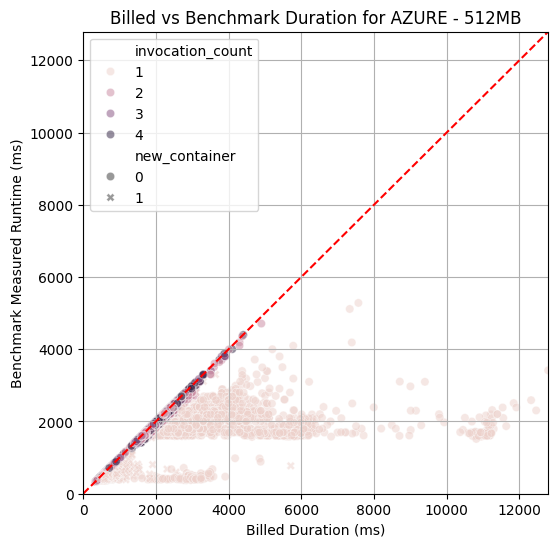

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_billed_vs_benchmark(provider, memory_size_mb):
    subset = df[(df["provider"] == provider) & (df["memory_size_mb"] == memory_size_mb) & (df["billed_duration_ms"].notnull())]

    # print id of records that have no new container but invocation count 1
    no_new_container = subset[(subset["new_container"] == 0)]
    print(no_new_container[["uuid", "new_container", "invocation_count"]])

    print(f"Plotting {provider} with {memory_size_mb}MB: {len(subset)} records")
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        data=subset,
        x="billed_duration_ms",
        y="runtime_ms",
        hue="invocation_count",
        style="new_container",
        alpha=0.5,
    )

    max_val = max(subset["billed_duration_ms"].max(), subset["runtime_ms"].max())
    plt.plot([0, max_val], [0, max_val], color="red", linestyle="--")
    plt.title(f"Billed vs Benchmark Duration for {provider.upper()} - {memory_size_mb}MB")
    plt.xlabel("Billed Duration (ms)")
    plt.ylabel("Benchmark Measured Runtime (ms)")
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.grid(True)
    plt.show()

# Example usage:
plot_billed_vs_benchmark("azure", 512)

In [4]:
from helpers.cpus import clean_cpu_string, shorten_cpu_name, get_cpu_palette
from helpers.benchmark import metric_for_benchmark

def filter_stage_cpu_data(df, provider, memory_size=512, region=None, benchmark="gemm", filter_on_timestamp=False):
    """
    Your original filtering logic with CPU normalization added.
    
    Filtering steps:
    1. Provider, memory size, benchmark, region filtering
    2. CPU name normalization
    3. Complete groups (4 invocations + 1 new_container)
    4. Tukey outlier removal
    5. Warm invocations only (invocation_count > 1)
    """

    # --- 1. Filter relevant subset ---
    df_filtered = df[
        (df["provider"] == provider) &
        (df["memory_size_mb"] == memory_size) &
        (df["benchmark_type"] == benchmark) & 
        ((region is None) | (df["region"] == region))
    ].copy()
    
    print(f"After basic filter: {len(df_filtered):,} records")
    
    if df_filtered.empty:
        print("❌ No data after basic filtering")
        return df_filtered
    
    # --- 2. CPU Name Normalization (NEW) ---
    df_filtered["cpu_type"] = df_filtered["cpu_type"].apply(clean_cpu_string)
    
    # --- 3. Complete Groups Filter ---
    # Only keep instances with all 4 invocations
    grouped = df_filtered.groupby("instance_id")
    valid_ids = [
        inst_id
        for inst_id, group in grouped
        if len(group) == 4
    ]
    
    df_filtered = df_filtered[df_filtered["instance_id"].isin(valid_ids)]
    print(f"After complete groups (4 inv + 1 new): {len(df_filtered):,} records")
    
    # --- 4. Tukey Outlier Filter ---
    metric = metric_for_benchmark(benchmark)
    df_filtered = df_filtered[df_filtered["invocation_count"] > 1]

    
    def is_outlier_tukey(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return (series < lower_bound) | (series > upper_bound)
    
    group_cols = ["cpu_type"] + (["timestamp"] if filter_on_timestamp else [])
    outlier_mask = df_filtered.groupby(group_cols)[metric].transform(is_outlier_tukey)
    bad_instances = df_filtered.loc[outlier_mask, "instance_id"].unique()
    df_filtered = df_filtered[~df_filtered["instance_id"].isin(bad_instances)]
    
    print(f"After Tukey outlier removal: {len(df_filtered):,} records")
    
    
    print(f"After warm-only filter: {len(df_filtered):,} records")
    print(f"Unique CPUs: {df_filtered['cpu_type'].nunique()}")
    print(f"Unique instances: {df_filtered['instance_id'].nunique()}")
    
    return df_filtered

After basic filter: 18,000 records
After complete groups (4 inv + 1 new): 13,248 records
After Tukey outlier removal: 9,459 records
After warm-only filter: 9,459 records
Unique CPUs: 5
Unique instances: 3153
After basic filter: 18,000 records
After complete groups (4 inv + 1 new): 14,748 records
After Tukey outlier removal: 10,488 records
After warm-only filter: 10,488 records
Unique CPUs: 5
Unique instances: 3496
After basic filter: 18,000 records
After complete groups (4 inv + 1 new): 15,528 records
After Tukey outlier removal: 11,430 records
After warm-only filter: 11,430 records
Unique CPUs: 5
Unique instances: 3810
After basic filter: 17,983 records
After complete groups (4 inv + 1 new): 15,588 records
After Tukey outlier removal: 11,655 records
After warm-only filter: 11,655 records
Unique CPUs: 3
Unique instances: 3885
After basic filter: 17,647 records
After complete groups (4 inv + 1 new): 15,760 records
After Tukey outlier removal: 11,328 records
After warm-only filter: 11,32

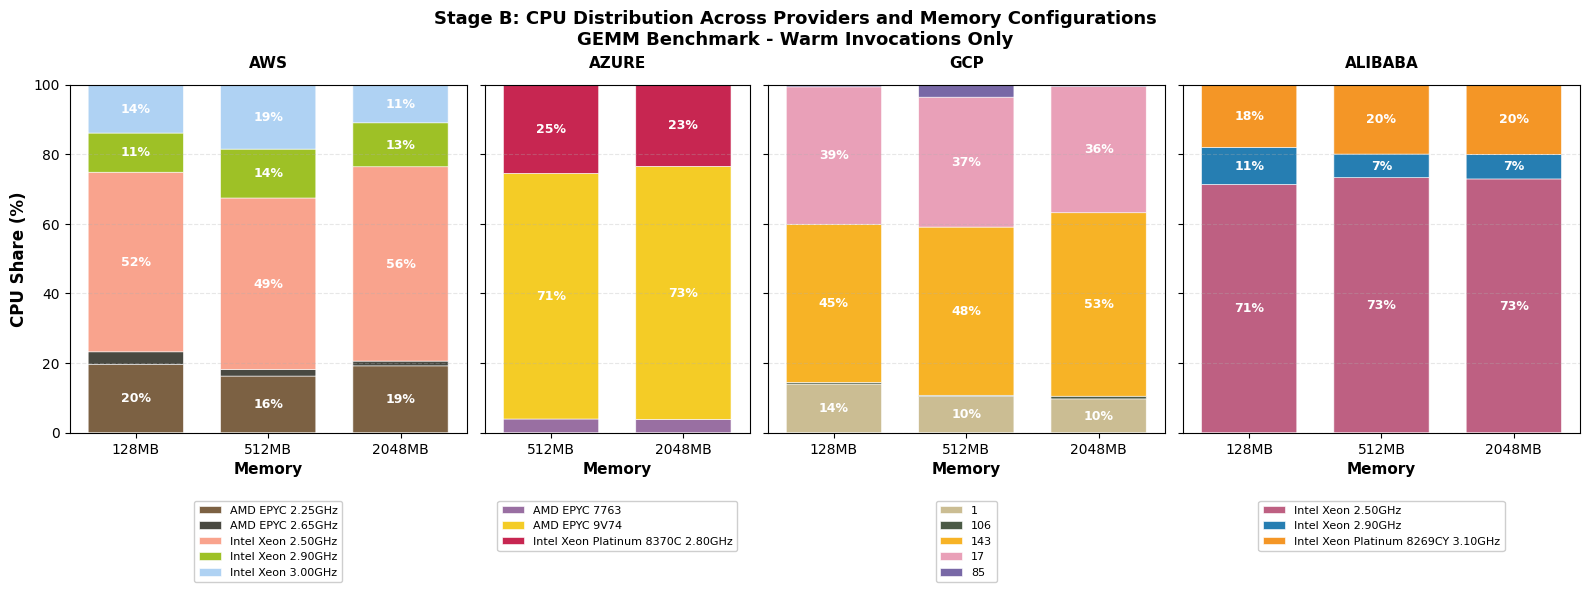

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import FancyBboxPatch
from helpers.cpus import shorten_cpu_name, get_cpu_color

def plot_stage_b_cpu_share(df, save_dir="../holy/plots/StageB"):
    """
    Plot CPU share across all providers and memory configurations.
    
    Creates vertical stacked bars showing CPU distribution:
    - 4 subplots (one per provider)
    - X-axis: Memory configurations (128MB, 512MB, 2048MB)
    - Y-axis: CPU Share (%)
    - Colors: Different CPU types (provider-aware)
    """
    
    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]
    benchmark = "gemm"
    
    # Collect data for all configurations
    results = []
    
    for provider in providers:
        # Azure only has 512MB and 2048MB
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes
        
        for memory_size in provider_memory_sizes:
            df_filtered = filter_stage_cpu_data(df, provider, memory_size, benchmark=benchmark)
            
            if df_filtered.empty:
                print(f"⚠️  No data for {provider} {memory_size}MB")
                continue
            
            # Calculate CPU distribution
            cpu_counts = df_filtered.groupby("cpu_type").size()
            total = cpu_counts.sum()
            
            for cpu, count in cpu_counts.items():
                results.append({
                    "provider": provider,
                    "memory_size": memory_size,
                    "cpu_type": cpu,
                    "count": count,
                    "percentage": (count / total * 100)
                })
    
    results_df = pd.DataFrame(results)
    
    if results_df.empty:
        print("❌ No data to plot")
        return
    
    # Create figure with 4 subplots - Azure is 2/3 width
    fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True,
                            gridspec_kw={'width_ratios': [3, 2, 3, 3]})
    
    bar_width = 0.7
    
    for idx, provider in enumerate(providers):
        ax = axes[idx]
        
        # Azure only has 512MB and 2048MB
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes
        
        # Filter data for this provider
        provider_data = results_df[results_df["provider"] == provider]
        
        n_configs = len(provider_memory_sizes)
        x_positions = np.arange(n_configs)
        
        if provider_data.empty:
            ax.text(0.5, 0.5, f"No data", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_xticks(x_positions)
            ax.set_xticklabels([f"{mem}MB" for mem in provider_memory_sizes], fontsize=10)
            ax.set_title(f"{provider.upper()}", fontweight='bold', fontsize=11, pad=12)
            continue
        
        # Get unique CPUs for this provider
        provider_cpus = sorted(provider_data["cpu_type"].unique())
        
        # Build pivot data - include ALL memory sizes for this provider
        pivot_data = {}
        for mem_size in provider_memory_sizes:
            mem_data = provider_data[provider_data["memory_size"] == mem_size]
            pivot_data[mem_size] = {
                row["cpu_type"]: row["percentage"]
                for _, row in mem_data.iterrows()
            }
        
        # Plot stacked bars with rounded corners
        bottom_positions = np.zeros(n_configs)
        legend_entries = {}
        
        for cpu_name in provider_cpus:
            heights = []
            
            for mem_size in provider_memory_sizes:
                heights.append(pivot_data[mem_size].get(cpu_name, 0))
            
            # Get color for this CPU with provider context
            color = get_cpu_color(cpu_name, provider=provider)
            
            # Draw rounded rectangles manually
            for i, height in enumerate(heights):
                if height > 0:
                    x_pos = x_positions[i] - bar_width/2
                    y_pos = bottom_positions[i]
                    
                    # Create rounded rectangle
                    fancy_box = FancyBboxPatch(
                        (x_pos, y_pos), bar_width, height,
                        boxstyle="round,pad=0.01",
                        edgecolor='white', facecolor=color,
                        linewidth=0.5, alpha=0.85,
                        transform=ax.transData
                    )
                    ax.add_patch(fancy_box)
                    
                    # Add percentage label
                    if height > 5:
                        ax.text(x_positions[i], y_pos + height/2, 
                               f'{height:.0f}%', 
                               ha='center', va='center', 
                               fontweight='bold', color='white', fontsize=9)
                    
                    # Add to legend (only once per CPU)
                    if cpu_name not in legend_entries:
                        cpu_label = shorten_cpu_name(cpu_name, 35)
                        legend_entries[cpu_name] = (fancy_box, cpu_label)
            
            bottom_positions += heights
        
        # Styling
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"{mem}MB" for mem in provider_memory_sizes], fontsize=10)
        ax.set_xlabel("Memory", fontweight='bold', fontsize=11)
        ax.set_ylim(0, 100)
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        
        # Tighter x-limits to squeeze bars together
        ax.set_xlim(-0.5, n_configs - 0.5)
        
        # Provider title with better padding
        ax.set_title(f"{provider.upper()}", fontweight='bold', fontsize=11, pad=12)
        
        # Add legend for this provider (below the plot)
        if legend_entries:
            handles = [entry[0] for entry in legend_entries.values()]
            labels = [entry[1] for entry in legend_entries.values()]
            ax.legend(handles, labels, 
                     loc='upper center', bbox_to_anchor=(0.5, -0.18), 
                     framealpha=0.95, fontsize=8, ncol=1)
    
    # Set y-axis label only on leftmost plot
    axes[0].set_ylabel("CPU Share (%)", fontweight='bold', fontsize=12)
    
    # Title with more spacing to avoid overlap
    fig.suptitle("Stage B: CPU Distribution Across Providers and Memory Configurations\n"
                 "GEMM Benchmark - Warm Invocations Only",
                 fontsize=13, fontweight='bold', y=0.985)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.86, bottom=0.28, wspace=0.05)
    
    # Save
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, "stage_b_cpu_share.pdf")
        plt.savefig(out_path, bbox_inches="tight", format='pdf')
        print(f"\n💾 Saved to: {out_path}")
    
    plt.show()


# Usage:
plot_stage_b_cpu_share(df)

After basic filter: 18,000 records
After complete groups (4 inv + 1 new): 13,248 records
After Tukey outlier removal: 9,459 records
After warm-only filter: 9,459 records
Unique CPUs: 5
Unique instances: 3153
After basic filter: 18,000 records
After complete groups (4 inv + 1 new): 14,748 records
After Tukey outlier removal: 10,488 records
After warm-only filter: 10,488 records
Unique CPUs: 5
Unique instances: 3496
After basic filter: 18,000 records
After complete groups (4 inv + 1 new): 15,528 records
After Tukey outlier removal: 11,430 records
After warm-only filter: 11,430 records
Unique CPUs: 5
Unique instances: 3810

AWS baseline CPU: Intel Xeon 2.50GHz
After basic filter: 17,983 records
After complete groups (4 inv + 1 new): 15,588 records
After Tukey outlier removal: 11,655 records
After warm-only filter: 11,655 records
Unique CPUs: 3
Unique instances: 3885
After basic filter: 17,647 records
After complete groups (4 inv + 1 new): 15,760 records
After Tukey outlier removal: 11,328

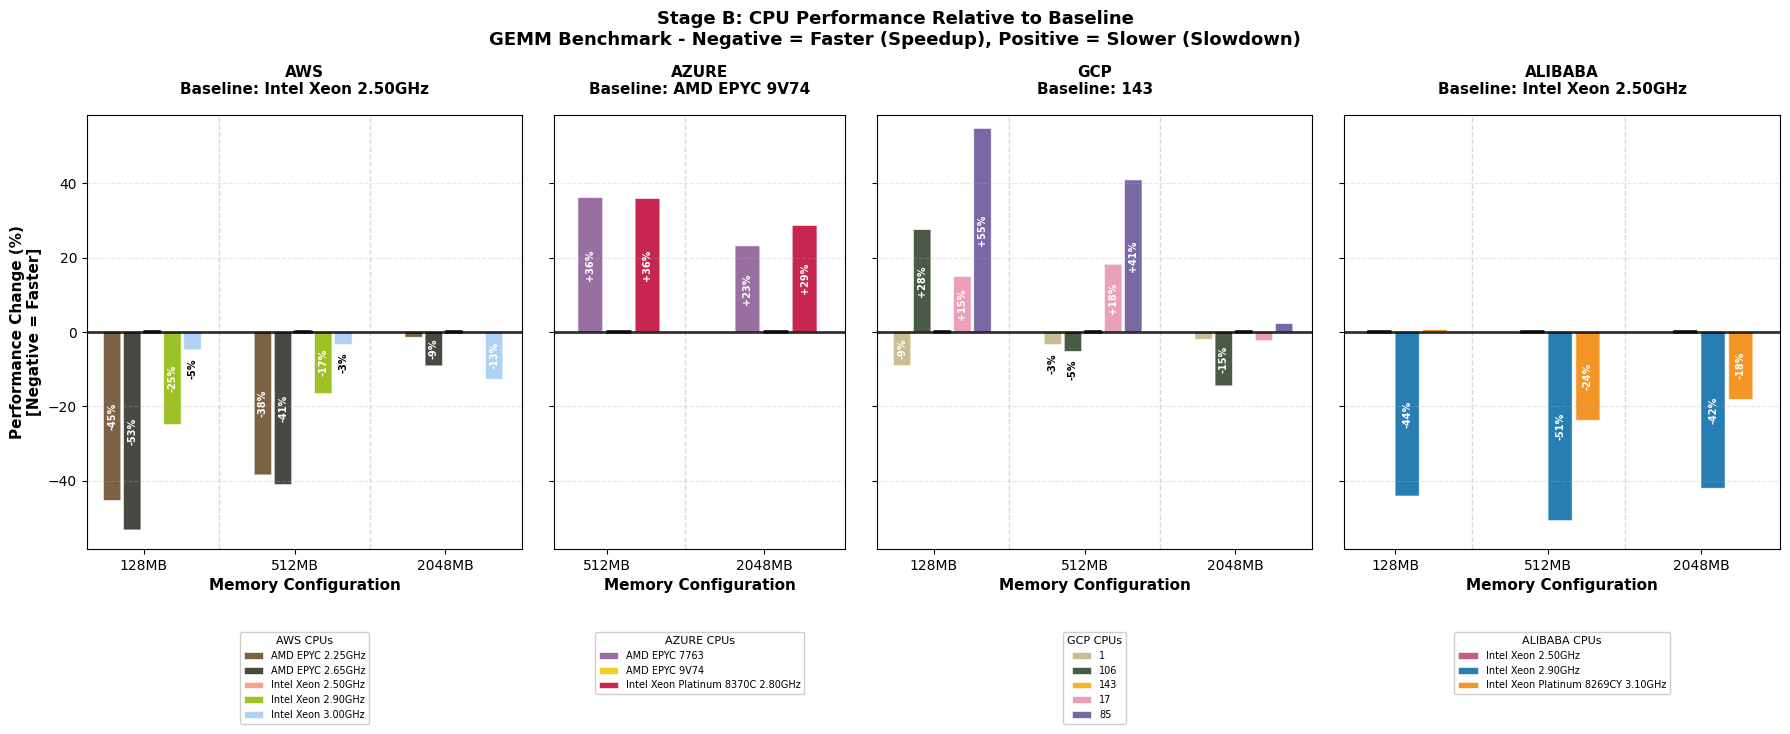

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import FancyBboxPatch, Rectangle
from helpers.cpus import clean_cpu_string, shorten_cpu_name, get_cpu_palette, get_cpu_color

def plot_stage_b_speedup(df, save_dir="../holy/plot/StageB"):
    """
    Plot speedup/slowdown relative to the most common CPU baseline for each provider.
    
    Creates one subplot per provider showing:
    - Baseline (most common CPU across all configs) = 0%
    - Negative bars = faster than baseline (speedup)
    - Positive bars = slower than baseline (slowdown)
    - All CPUs shown for each configuration
    """
    
    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]
    benchmark = "gemm"
    metric = "multiplication_time_ms"
    
    # Create figure with 4 subplots - Azure is 2/3 width
    fig, axes = plt.subplots(1, 4, figsize=(18, 7), sharey=True,
                            gridspec_kw={'width_ratios': [3, 2, 3, 3]})
    
    for idx, provider in enumerate(providers):
        ax = axes[idx]
        
        # For Azure, skip 128MB configuration
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes
        
        # Collect all data for this provider across all configs
        all_provider_data = []
        provider_data_by_config = {}
        
        for memory_size in provider_memory_sizes:
            df_filtered = filter_stage_cpu_data(df, provider, memory_size, benchmark=benchmark)
            
            if not df_filtered.empty:
                all_provider_data.append(df_filtered)
                provider_data_by_config[memory_size] = df_filtered
        
        if not all_provider_data:
            ax.text(0.5, 0.5, f"No data", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f"{provider.upper()}", fontweight='bold', fontsize=11, pad=15)
            continue
        
        # Find most common CPU across ALL configurations for this provider
        combined_df = pd.concat(all_provider_data, ignore_index=True)
        baseline_cpu = combined_df["cpu_type"].value_counts().idxmax()
        
        print(f"\n{provider.upper()} baseline CPU: {baseline_cpu}")
        
        # Get all unique CPUs for this provider for legend
        all_provider_cpus = sorted(combined_df["cpu_type"].unique())
        
        # Collect speedup data for plotting
        all_plot_data = {}
        
        for memory_size in provider_memory_sizes:
            if memory_size not in provider_data_by_config:
                all_plot_data[memory_size] = []
                continue
                
            df_config = provider_data_by_config[memory_size]
            
            # Get baseline performance for THIS configuration
            baseline_data = df_config[df_config["cpu_type"] == baseline_cpu][metric]
            
            if len(baseline_data) == 0:
                print(f"  ⚠️  No baseline CPU data for {memory_size}MB")
                all_plot_data[memory_size] = []
                continue
            
            baseline_perf_config = baseline_data.mean()
            
            # Calculate speedup/slowdown for each CPU in this config
            cpu_perf = df_config.groupby("cpu_type")[metric].mean().sort_index()
            
            config_data = []
            for cpu, perf in cpu_perf.items():
                # Percentage change: (cpu_time - baseline_time) / baseline_time * 100
                pct_change = (perf - baseline_perf_config) / baseline_perf_config * 100
                
                config_data.append({
                    "cpu_type": cpu,
                    "pct_change": pct_change,
                    "is_baseline": cpu == baseline_cpu
                })
            
            all_plot_data[memory_size] = config_data
        
        # Calculate positions for bars
        bar_width = 0.6
        config_gap = 1.5
        current_x = 0
        
        config_centers = []
        bar_positions = []
        
        for memory_size in provider_memory_sizes:
            config_data = all_plot_data.get(memory_size, [])
            
            if not config_data:
                config_centers.append(current_x)
                current_x += config_gap
                continue
            
            n_bars = len(config_data)
            config_start = current_x
            
            for bar_idx, data in enumerate(config_data):
                x_pos = config_start + bar_idx * bar_width
                bar_positions.append({
                    "x": x_pos,
                    "memory_size": memory_size,
                    "cpu": data["cpu_type"],
                    "pct_change": data["pct_change"],
                    "is_baseline": data["is_baseline"]
                })
            
            # Store center of this config for x-tick
            config_center = config_start + (n_bars - 1) * bar_width / 2
            config_centers.append(config_center)
            
            current_x = config_start + n_bars * bar_width + config_gap
        
        # Plot all bars
        for bar_data in bar_positions:
            x_pos = bar_data["x"]
            pct_change = bar_data["pct_change"]
            cpu = bar_data["cpu"]
            is_baseline = bar_data["is_baseline"]
            
            # Get color for this CPU
            color = get_cpu_color(cpu, provider=provider)
            
            # Draw rounded bar
            bar_width_actual = bar_width * 0.85
            
            if pct_change < 0:  # Faster (negative)
                fancy_box = FancyBboxPatch(
                    (x_pos, pct_change), bar_width_actual, -pct_change,
                    boxstyle="round,pad=0.005",
                    edgecolor='black' if is_baseline else 'white',
                    facecolor=color,
                    linewidth=2 if is_baseline else 0.5,
                    alpha=0.85,
                    transform=ax.transData
                )
            else:  # Slower (positive) or baseline (0)
                fancy_box = FancyBboxPatch(
                    (x_pos, 0), bar_width_actual, pct_change,
                    boxstyle="round,pad=0.005",
                    edgecolor='black' if is_baseline else 'white',
                    facecolor=color,
                    linewidth=2 if is_baseline else 0.5,
                    alpha=0.85,
                    transform=ax.transData
                )
            ax.add_patch(fancy_box)
            
            # Add percentage label
            if abs(pct_change) > 3:
                if abs(pct_change) > 8:
                    # Inside the bar
                    label_y = pct_change / 2
                    label_color = 'white'
                else:
                    # Outside the bar
                    label_offset = 5
                    if pct_change > 0:
                        label_y = pct_change + label_offset
                    else:
                        label_y = pct_change - label_offset
                    label_color = 'black'
                
                ax.text(x_pos + bar_width_actual / 2, label_y, 
                       f'{pct_change:+.0f}%', 
                       ha='center', va='center', 
                       fontweight='bold', color=label_color, 
                       fontsize=7, rotation=90)
        
        # Add vertical separators between configurations
        for mem_idx in range(len(provider_memory_sizes) - 1):
            if mem_idx < len(config_centers) - 1:
                separator_x = (config_centers[mem_idx] + config_centers[mem_idx + 1]) / 2
                ax.axvline(x=separator_x, color='gray', linestyle='--', 
                          linewidth=1, alpha=0.3, zorder=1)
        
        # Add baseline line at y=0
        ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.8, zorder=10)
        
        # Styling
        if idx == 0:
            ax.set_ylabel("Performance Change (%)\n[Negative = Faster]", 
                         fontweight='bold', fontsize=11)
        
        # Set x-ticks at configuration centers
        ax.set_xticks(config_centers)
        ax.set_xticklabels([f"{mem}MB" for mem in provider_memory_sizes], fontsize=10)
        ax.set_xlabel("Memory Configuration", fontweight='bold', fontsize=11)
        
        ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
        ax.set_title(f"{provider.upper()}\nBaseline: {shorten_cpu_name(baseline_cpu, 30)}", 
                    fontweight='bold', fontsize=11, pad=15)
        
        # Set y-limits
        if bar_positions:
            all_changes = [b["pct_change"] for b in bar_positions]
            max_abs = max(abs(min(all_changes)), abs(max(all_changes)))
            ax.set_ylim(-max_abs * 1.15, max_abs * 1.15)
        
        # Set x-limits
        if bar_positions:
            ax.set_xlim(-0.5, max([b["x"] for b in bar_positions]) + bar_width + 0.5)
        
        # Add legend for this provider
        legend_handles = []
        legend_labels = []
        for cpu in all_provider_cpus:
            color = get_cpu_color(cpu, provider=provider)
            patch = Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='white', linewidth=0.5, alpha=0.85)
            legend_handles.append(patch)
            legend_labels.append(shorten_cpu_name(cpu, 30))
        
        ax.legend(legend_handles, legend_labels, 
                 loc='upper center', bbox_to_anchor=(0.5, -0.18),
                 framealpha=0.95, fontsize=7, ncol=1,
                 title=f'{provider.upper()} CPUs', title_fontsize=8)
    
    fig.suptitle("Stage B: CPU Performance Relative to Baseline\n"
                 "GEMM Benchmark - Negative = Faster (Speedup), Positive = Slower (Slowdown)",
                 fontsize=13, fontweight='bold', y=0.99)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.84, bottom=0.22, wspace=0.08)
    
    # Save
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, "stage_b_speedup.pdf")
        plt.savefig(out_path, bbox_inches="tight", format='pdf')
        print(f"\n💾 Saved to: {out_path}")
    
    plt.show()


# Usage:
plot_stage_b_speedup(df)

After basic filter: 18,000 records
After complete groups (4 inv + 1 new): 15,160 records
After Tukey outlier removal: 10,407 records
After warm-only filter: 10,407 records
Unique CPUs: 5
Unique instances: 3469


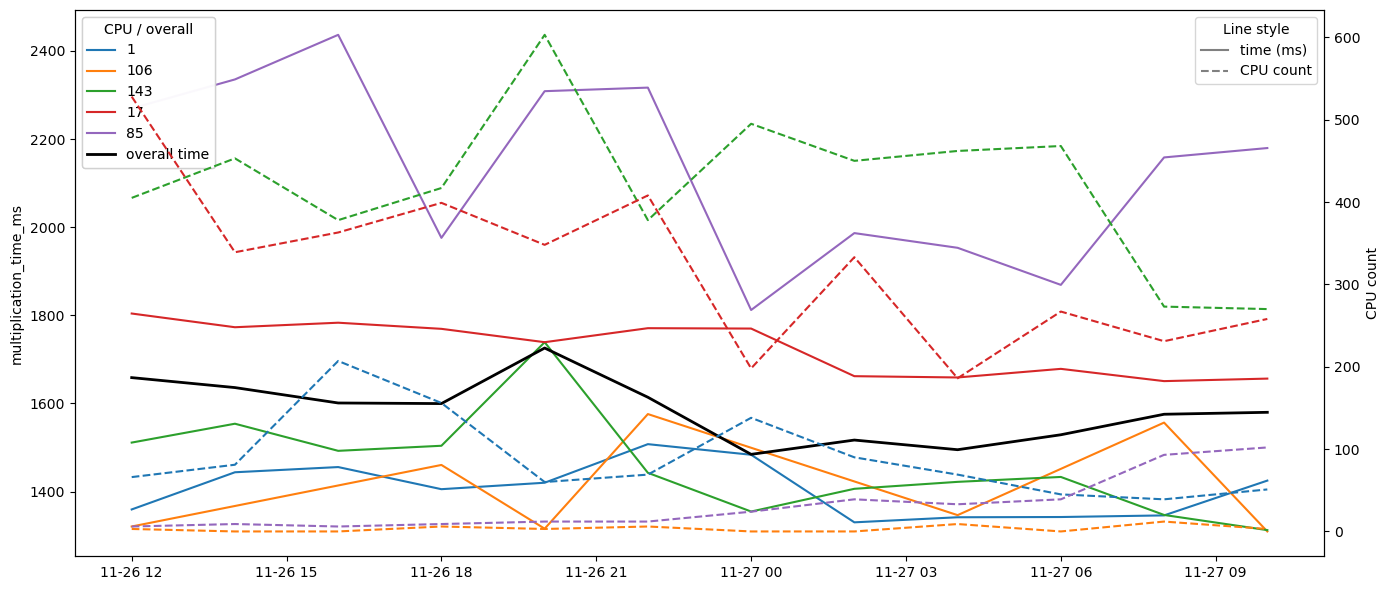

In [29]:
filtered = filter_stage_cpu_data(df, provider="gcp", memory_size=512, benchmark="gemm", filter_on_timestamp=True)


cpu_count_per_timestamp = filtered.groupby(["timestamp", "cpu_type"]).size().unstack(fill_value=0)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- prepare data --------------------------------------------------------

# mean time per cpu_type & timestamp
lat_per_cpu = (
    filtered
    .groupby(["timestamp", "cpu_type"])["multiplication_time_ms"]
    .mean()
    .reset_index()
)

# overall mean time per timestamp
overall = (
    filtered
    .groupby("timestamp")["multiplication_time_ms"]
    .mean()
    .reset_index()
)

# counts per cpu_type & timestamp -> long form
cpu_counts_long = (
    cpu_count_per_timestamp
    .reset_index()
    .melt(id_vars="timestamp",
          var_name="cpu_type",
          value_name="cpu_count")
)

cpu_types = sorted(lat_per_cpu["cpu_type"].unique())
palette = dict(zip(cpu_types, sns.color_palette(n_colors=len(cpu_types))))

# --- plotting -----------------------------------------------------------

fig, ax1 = plt.subplots(figsize=(14, 6))

# left axis: time per cpu_type (solid)
for cpu in cpu_types:
    df_cpu = lat_per_cpu[lat_per_cpu["cpu_type"] == cpu]
    ax1.plot(
        df_cpu["timestamp"],
        df_cpu["multiplication_time_ms"],
        label=cpu,
        color=palette[cpu],
    )
ax1.set_ylabel("multiplication_time_ms")

# overall mean time (thick black line)
ax1.plot(
    overall["timestamp"],
    overall["multiplication_time_ms"],
    color="black",
    linewidth=2,
    label="overall time",
)

# right axis: counts per cpu_type (dashed, same colors)
ax2 = ax1.twinx()
for cpu in cpu_types:
    dfc = cpu_counts_long[cpu_counts_long["cpu_type"] == cpu]
    ax2.plot(
        dfc["timestamp"],
        dfc["cpu_count"],
        linestyle="--",
        color=palette[cpu],
    )
ax2.set_ylabel("CPU count")

# --- legends ------------------------------------------------------------

# legend 1: which color is which CPU / overall
handles1, labels1 = ax1.get_legend_handles_labels()
leg1 = ax1.legend(handles1, labels1, loc="upper left", title="CPU / overall")

# legend 2: what the line styles mean
style_lines = [
    Line2D([0], [0], linestyle="-", color="gray", label="time (ms)"),
    Line2D([0], [0], linestyle="--", color="gray", label="CPU count"),
]
ax2.legend(style_lines, ["time (ms)", "CPU count"],
           loc="upper right", title="Line style")

ax1.add_artist(leg1)

plt.tight_layout()
plt.show()

